In [31]:
from google.colab import files
files.upload()



Saving IPl_Matches.csv to IPl_Matches (1).csv
Saving IPL_Deliveries.csv.zip to IPL_Deliveries.csv (1).zip


{'IPl_Matches (1).csv': b'id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2\r\n335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,223,20,N,NA,Asad Rauf,RE Koertzen\r\n335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33,241,20,N,NA,MR Benson,SL Shastri\r\n335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9,130,20,N,NA,Aleem Dar,GA Pratapkumar\r\n335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Ba

In [32]:
import zipfile

with zipfile.ZipFile("IPL_Deliveries.csv.zip", 'r') as zip_ref:
    zip_ref.extractall()

print("ZIP extracted successfully")



ZIP extracted successfully


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

matches = pd.read_csv("IPl_Matches.csv")
deliveries = pd.read_csv("deliveries.csv")

print("Matches:", matches.shape)
print("Deliveries:", deliveries.shape)

Matches: (1095, 20)
Deliveries: (260920, 17)


In [34]:
# Remove abandoned matches
matches = matches.dropna(subset=['winner'])

# Verify seasons
print("Seasons:", matches['season'].unique())


Seasons: ['2007/08' '2009' '2009/10' '2011' '2012' '2013' '2014' '2015' '2016'
 '2017' '2018' '2019' '2020/21' '2021' '2022' '2023' '2024']


In [35]:
# Filter seasons
# Convert 'season' to integer type by extracting the first 4 characters (the year)
matches['season_year'] = matches['season'].str[:4].astype(int)
matches_12 = matches[matches['season_year'].between(2008, 2019)]

# Merge
ipl_data = deliveries.merge(
    matches_12[['id','season','winner','venue']],
    left_on='match_id',
    right_on='id',
    how='inner'
)

# Cleaning
ipl_data['player_dismissed'] = ipl_data['player_dismissed'].fillna("Not Out")
ipl_data['ball'] = 1

print("Final shape:", ipl_data.shape)
print("Total matches:", ipl_data['match_id'].nunique())

Final shape: (165197, 21)
Total matches: 694


In [36]:
player_stats = ipl_data.groupby('batter').agg({
    'batsman_runs':'sum',
    'ball':'count'
}).reset_index()

player_stats['strike_rate'] = (player_stats['batsman_runs'] /
                               player_stats['ball']) * 100

# Filter serious players
player_stats = player_stats[player_stats['ball'] > 500]

player_stats.head()


batter  batsman_runs  ball  strike_rate
12       A Symonds           813   670   121.343284
22  AB de Villiers          4246  2825   150.300885
24    AC Gilchrist          1633  1227   133.088835
29      AD Mathews           723   596   121.308725
31      AD Russell          1404   803   174.844334

In [37]:
runs_per_match = ipl_data.groupby(
    ['batter','match_id']
)['batsman_runs'].sum().reset_index()

consistency = runs_per_match.groupby('batter')['batsman_runs'].agg(
    ['mean','std']
).reset_index()

# Filter for serious players who have played more than 500 balls (from player_stats)
# Assuming 'player_stats' is already filtered for ball > 500
serious_batters = player_stats['batter'].unique()
consistency_filtered = consistency[consistency['batter'].isin(serious_batters)].copy()

# Handle NaN in 'std' that might arise if a serious player only played one match.
# For consistency analysis, players with NaN std cannot be compared, so we drop them.
consistency_filtered.dropna(subset=['std'], inplace=True)

consistency = consistency_filtered.sort_values(['std','mean'],
                                      ascending=[True, False])

top10_consistent = consistency.head(10)
top10_consistent

batter       mean        std
335        RA Jadeja  15.448276  11.183330
47          AR Patel  12.838710  11.676224
151  Harbhajan Singh   9.626506  11.774001
416        STR Binny  13.333333  12.057980
158        IK Pathan  14.152778  12.810273
466  Y Venugopal Rao  17.000000  13.418271
169        JA Morkel  12.877193  13.829407
110         DJ Bravo  14.184783  14.766259
29        AD Mathews  18.075000  14.846890
141        GJ Bailey  18.416667  15.457546

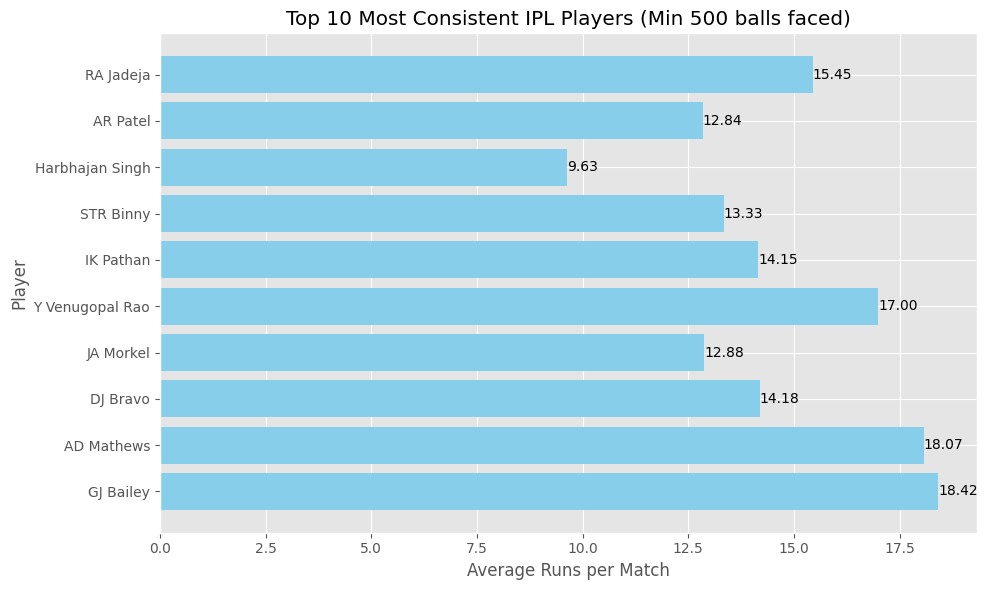

In [38]:
plt.figure(figsize=(10, 6)) # Increase figure size for better readability
bars = plt.barh(top10_consistent['batter'],
                top10_consistent['mean'],
                color='skyblue') # Use a color

plt.xlabel("Average Runs per Match")
plt.ylabel("Player") # Add y-label for clarity
plt.title("Top 10 Most Consistent IPL Players (Min 500 balls faced)") # Update title
plt.gca().invert_yaxis() # Invert y-axis to have the highest value on top

# Add data labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}', # Format to 2 decimal places
             va='center', ha='left', fontsize=10) # Adjust text properties

plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

In [39]:
# Boundary %
ipl_data['is_boundary'] = ipl_data['batsman_runs'].isin([4,6])
boundary_pct = ipl_data.groupby('batter')['is_boundary'].mean()*100


In [40]:
bowler_stats = ipl_data.groupby('bowler').agg({
    'total_runs':'sum',
    'ball':'count',
    'player_dismissed':'count'
}).reset_index()

bowler_stats.rename(columns={'player_dismissed':'wickets'},
                    inplace=True)

bowler_stats['economy'] = (bowler_stats['total_runs'] /
                           bowler_stats['ball']) * 6

bowler_stats.head()


bowler  total_runs  ball  wickets    economy
0  A Ashish Reddy         400   270      270   8.888889
1      A Chandila         245   234      234   6.282051
2     A Choudhary         144   108      108   8.000000
3     A Dananjaya          47    25       25  11.280000
4      A Flintoff         106    66       66   9.636364

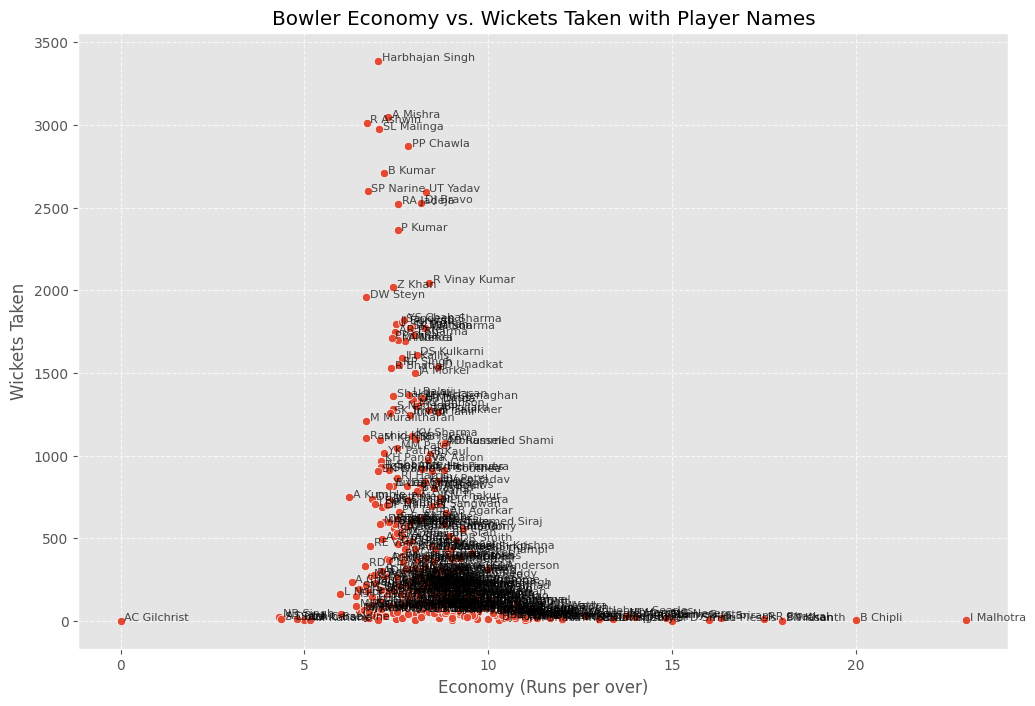

In [41]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='economy', y='wickets', data=bowler_stats)

# Add names to the data points for better readability
for i, row in bowler_stats.iterrows():
    # Only label bowlers with significant wickets or economy to avoid clutter
    if row['wickets'] > 50 or row['economy'] > 10 or row['economy'] < 6:
        plt.text(row['economy'] + 0.1, row['wickets'], row['bowler'], fontsize=8, alpha=0.7)

plt.xlabel('Economy (Runs per over)')
plt.ylabel('Wickets Taken')
plt.title('Bowler Economy vs. Wickets Taken with Player Names')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

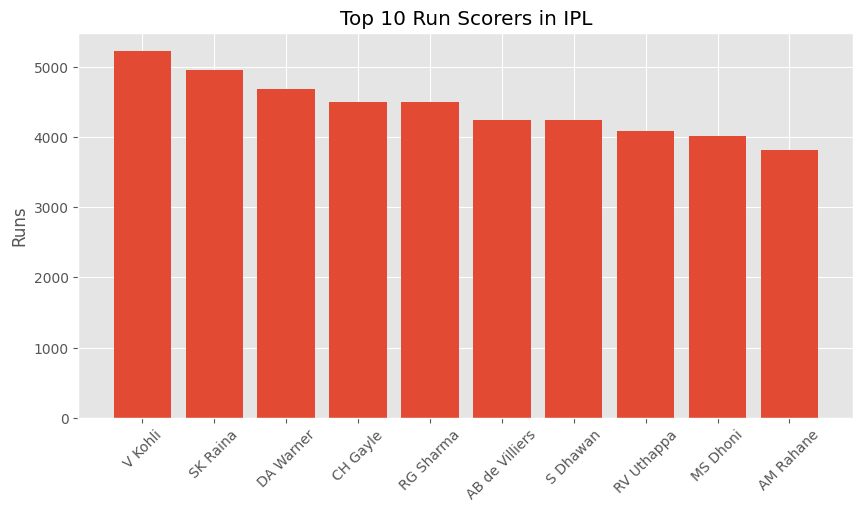

In [42]:
top_runs = player_stats.sort_values(
    'batsman_runs', ascending=False
).head(10)

plt.figure(figsize=(10,5))
plt.bar(top_runs['batter'],
        top_runs['batsman_runs'])
plt.xticks(rotation=45)
plt.title("Top 10 Run Scorers in IPL")
plt.ylabel("Runs")
plt.show()


In [44]:
# Feature Engineering
ipl_data['is_boundary'] = ipl_data['batsman_runs'].isin([4,6]).astype(int)
ipl_data['is_dot_ball'] = (ipl_data['total_runs'] == 0).astype(int)
ipl_data['is_wicket'] = (ipl_data['player_dismissed'] != "Not Out").astype(int)


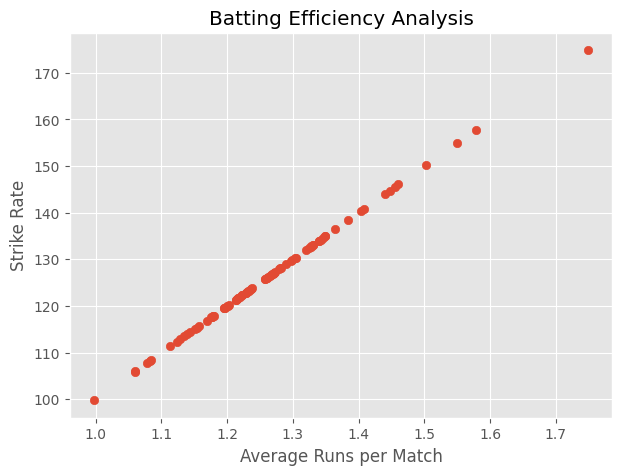

In [45]:
plt.figure(figsize=(7,5))
plt.scatter(player_kpis['avg_runs_per_match'],
            player_kpis['strike_rate'])

plt.xlabel("Average Runs per Match")
plt.ylabel("Strike Rate")
plt.title("Batting Efficiency Analysis")
plt.show()


## Visualize Top Batting Performers

### Subtask:
Generate visualizations (e.g., bar charts) to highlight the top batters based on their performance in the calculated key metrics such as Total Runs, Strike Rate, Boundary Percentage, and Average Runs Per Match. Ensure clear labels and titles are provided.


**Reasoning**:
I will generate four bar charts to visualize the top 10 batters based on 'total_runs', 'strike_rate', 'boundary_percentage', and 'avg_runs_per_match' respectively, as specified in the instructions. Each plot will be created in its own figure for clarity, with appropriate labels and titles.



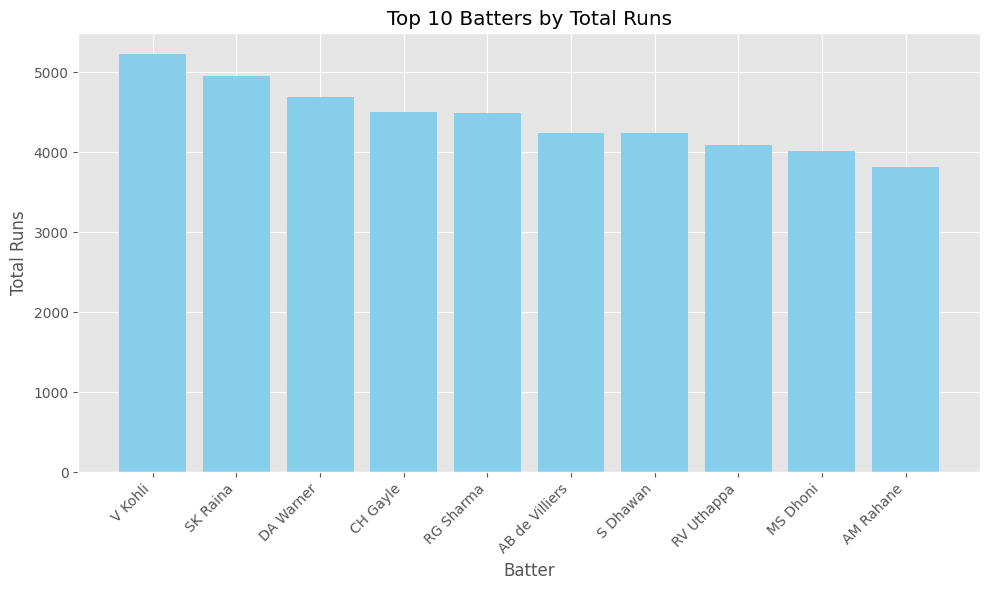

In [53]:
import matplotlib.pyplot as plt

# 1. Top 10 Batters by Total Runs
top10_total_runs = player_kpis.sort_values('total_runs', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_total_runs['batter'], top10_total_runs['total_runs'], color='skyblue')
plt.xlabel('Batter')
plt.ylabel('Total Runs')
plt.title('Top 10 Batters by Total Runs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


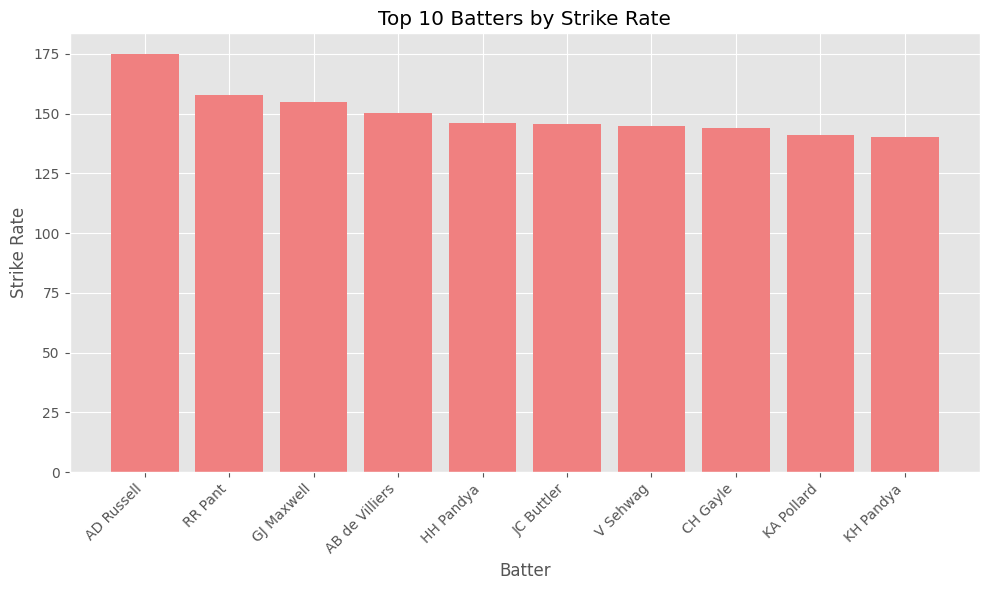

In [54]:
# 2. Top 10 Batters by Strike Rate
top10_strike_rate = player_kpis.sort_values('strike_rate', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_strike_rate['batter'], top10_strike_rate['strike_rate'], color='lightcoral')
plt.xlabel('Batter')
plt.ylabel('Strike Rate')
plt.title('Top 10 Batters by Strike Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


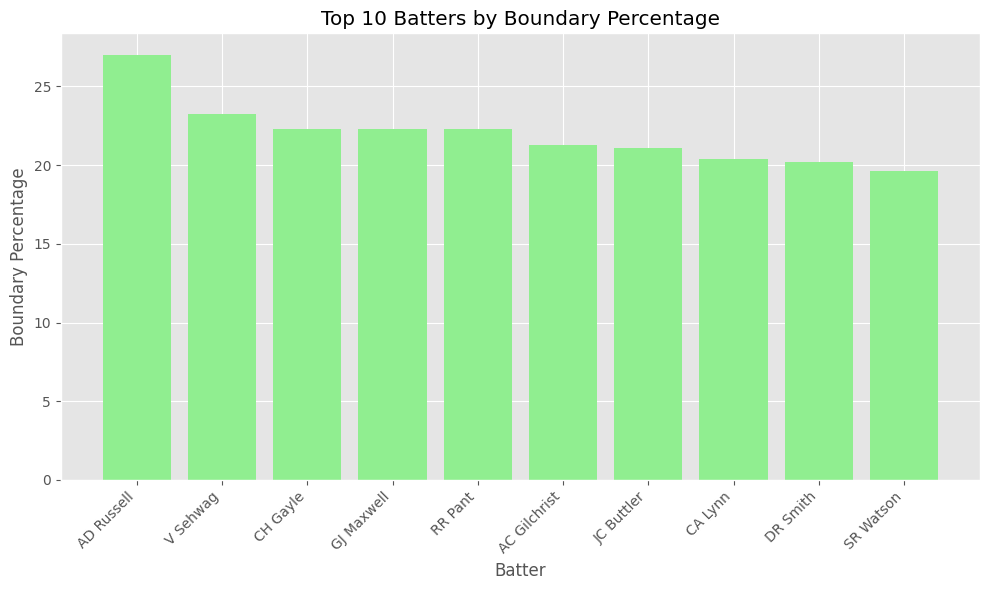

In [55]:
# 3. Top 10 Batters by Boundary Percentage
top10_boundary_pct = player_kpis.sort_values('boundary_percentage', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_boundary_pct['batter'], top10_boundary_pct['boundary_percentage'], color='lightgreen')
plt.xlabel('Batter')
plt.ylabel('Boundary Percentage')
plt.title('Top 10 Batters by Boundary Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

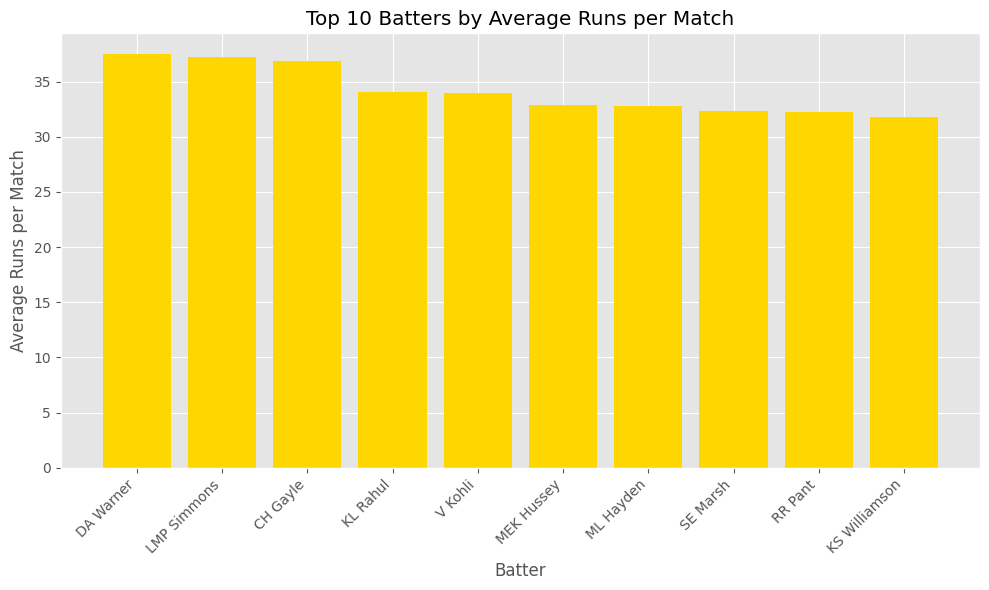

In [56]:
# 4. Top 10 Batters by Average Runs per Match
top10_avg_runs_per_match = player_kpis.sort_values('avg_runs_per_match', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_avg_runs_per_match['batter'], top10_avg_runs_per_match['avg_runs_per_match'], color='gold')
plt.xlabel('Batter')
plt.ylabel('Average Runs per Match')
plt.title('Top 10 Batters by Average Runs per Match')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualize Top Bowling Performers

### Subtask:
Generate visualizations (e.g., bar charts) to highlight the top bowlers based on their performance in the calculated key metrics such as Total Wickets, Economy Rate, Dot Ball Percentage, and Bowling Strike Rate. Ensure clear labels and titles are provided.


**Reasoning**:
I will generate four bar charts to visualize the top 10 bowlers based on 'wickets_taken', 'economy', 'dot_ball_percentage', and 'bowling_strike_rate' respectively, as specified in the instructions. Each plot will be created in its own figure for clarity, with appropriate labels and titles, and x-axis labels rotated for readability.



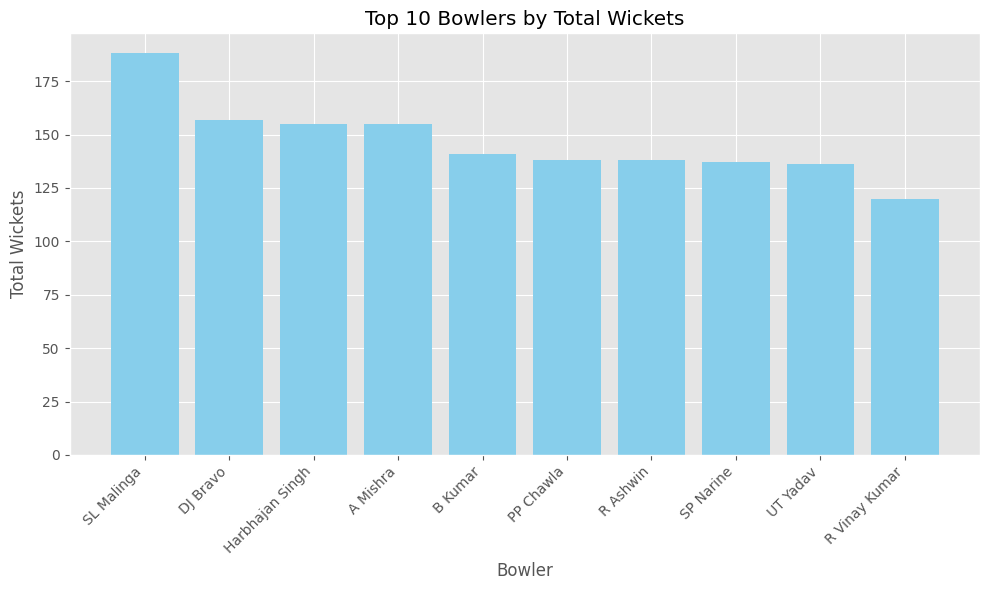

In [57]:
import matplotlib.pyplot as plt

# 1. Top 10 Bowlers by Total Wickets
top10_wickets = bowler_kpis.sort_values('wickets_taken', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_wickets['bowler'], top10_wickets['wickets_taken'], color='skyblue')
plt.xlabel('Bowler')
plt.ylabel('Total Wickets')
plt.title('Top 10 Bowlers by Total Wickets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

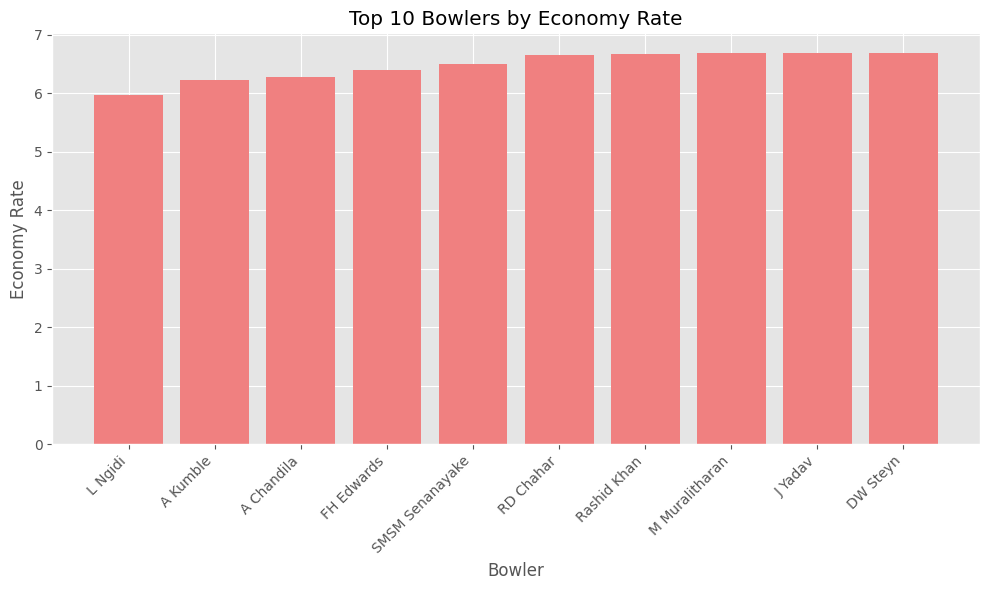

In [58]:
# 2. Top 10 Bowlers by Economy Rate (lower is better)
top10_economy = bowler_kpis.sort_values('economy', ascending=True).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_economy['bowler'], top10_economy['economy'], color='lightcoral')
plt.xlabel('Bowler')
plt.ylabel('Economy Rate')
plt.title('Top 10 Bowlers by Economy Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

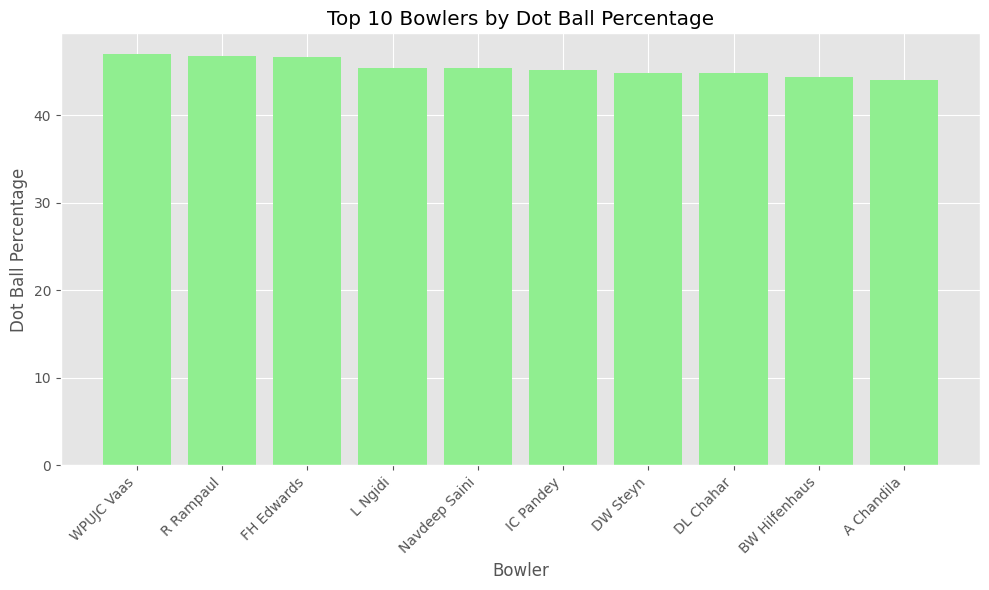

In [59]:
# 3. Top 10 Bowlers by Dot Ball Percentage
top10_dot_ball_pct = bowler_kpis.sort_values('dot_ball_percentage', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_dot_ball_pct['bowler'], top10_dot_ball_pct['dot_ball_percentage'], color='lightgreen')
plt.xlabel('Bowler')
plt.ylabel('Dot Ball Percentage')
plt.title('Top 10 Bowlers by Dot Ball Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

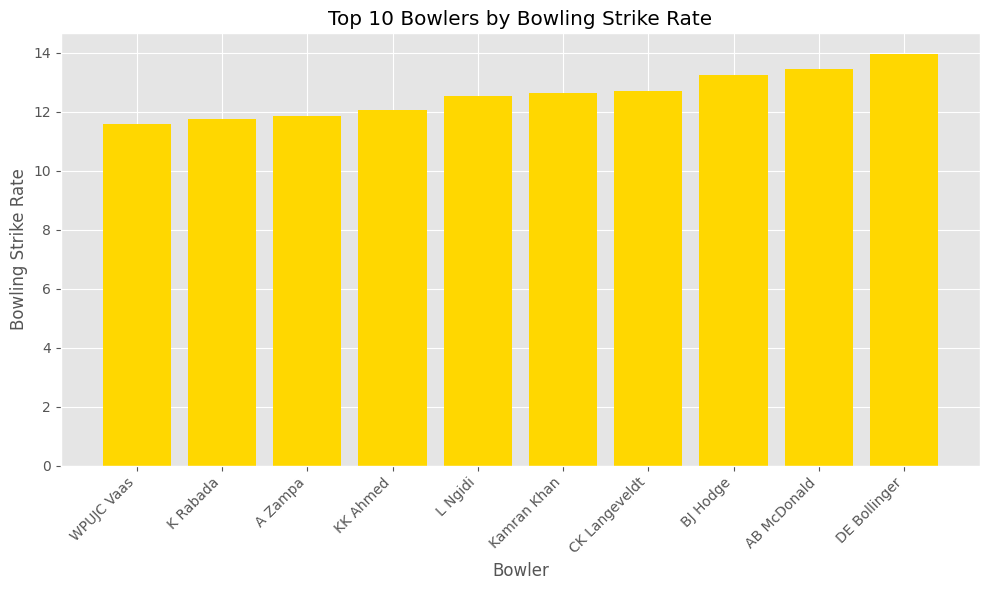

In [60]:
# 4. Top 10 Bowlers by Bowling Strike Rate (lower is better)
top10_bowling_strike_rate = bowler_kpis.sort_values('bowling_strike_rate', ascending=True).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_bowling_strike_rate['bowler'], top10_bowling_strike_rate['bowling_strike_rate'], color='gold')
plt.xlabel('Bowler')
plt.ylabel('Bowling Strike Rate')
plt.title('Top 10 Bowlers by Bowling Strike Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [43]:
!pip install xlsxwriter

with pd.ExcelWriter("IPL_Analysis_Summary.xlsx",
                    engine='xlsxwriter') as writer:
    player_stats.to_excel(writer,
                           sheet_name='Batting Stats',
                           index=False)
    bowler_stats.to_excel(writer,
                           sheet_name='Bowling Stats',
                           index=False)
    top10_consistent.to_excel(writer,
                              sheet_name='Consistent Players',
                              index=False)

print("Excel file created")

Excel file created
